# Q2 - A Generative Model for Pokemon Unown (50 pts)

![](https://github.com/lopeLH/unown-mnist/blob/main/doc/examples.png?raw=true)


In this question, we'll fit a Bernoulli Naïve Bayes model to the pokemon dataset, and use this model for making predictions and generating new images from the same distribution. pokemon is a dataset of 28x28 images of items of pokemon symbols.

We represent each image by a vector $x^{(i)} \in \{0,1\}^{D}$, where 0 and 1 represent white and black pixels respectively, and $D=784$. Each class label $c^{(i)}$ is a different item of clothing, which in the code is represented by a K=10-dimensional one-hot vector.

The Bernoulli Naïve Bayes model parameterized by $\theta$ and $\pi$ defines the following joint probability of $x$ and $c$,
$$p(x,c|\theta,\pi) = p(c|\pi)p(x|c,\theta) = p(c|\pi)\prod_{j=1}^{D}p(x_j|c,\theta),$$
where $x_j | c,\theta \sim \operatorname{Bernoulli}(\theta_{jc})$, i.e. $p(x_j | c,\theta) = \theta_{jc}^{x_j}(1-\theta_{jc})^{1-x_j}$, and $c|\pi$ follows a simple categorical distribution, i.e. $p(c|\pi) = \pi_c$.

We begin by learning the parameters $\theta$ and $\pi$.

First The following code will download and prepare the training and test sets.

In [1]:
import numpy as np
import os
import gzip
import struct
import array
import matplotlib.pyplot as plt
import matplotlib.image
from urllib.request import urlretrieve

def download(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file = os.path.join('data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)


def unown_mnist():
    base_url = 'https://github.com/lopeLH/unown-mnist/raw/refs/heads/main/'
    X_test_url = 'X_test.npy'
    X_train_url = 'X_train.npy'
    y_train_url = 'Y_train.npy'
    y_test_url = 'Y_test.npy'

    for filename in [X_train_url,X_test_url,
                     y_train_url,y_test_url]:
        download(base_url + filename, filename)

    X_train =  np.load('./data/X_train.npy')
    X_test =  np.load('./data/X_test.npy')
    Y_train =  np.load('./data/Y_train.npy')
    Y_test =  np.load('./data/Y_test.npy')

    return X_train,Y_train, X_test, Y_test

def load_unown_mnist():
    partial_flatten = lambda x: np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))

    one_hot = lambda x, k: np.array(x[:, None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels = unown_mnist()
    num_unique_labels = len(np.unique(train_labels))
    train_images = (partial_flatten(train_images) / 255.0).astype(float)
    test_images = (partial_flatten(test_images) / 255.0).astype(float)
    train_images_binarized = (train_images > 0.5).astype(float)
    test_images_binarized = (test_images > 0.5).astype(float)
    train_labels = one_hot(train_labels, num_unique_labels)
    test_labels = one_hot(test_labels, num_unique_labels)
    N_data = train_images.shape[0]

    return N_data, train_images, train_images_binarized, train_labels, test_images, test_images_binarized, test_labels

In [2]:
N_data, train_images, train_images_binarized, train_labels, test_images, test_images_binarized, test_labels = load_unown_mnist()

## Q2.1
[4pts] Derive the expression for the Maximum Likelihood Estimator (MLE) of $\theta$ and $\pi$.

Let $D={(x^{(1)},c^{(1)}), (x^{(2)},c^{(2)}), ..., (x^{(n)},c^{(n)})}.$
$$L=\prod_{i=1}^{n}P(c^{(i)}|\pi)\prod_{j=1}^{D}\theta_{jc^{(i)}}^{x_j^{(i)}}(1-\theta_{jc^{(i)}})^{x_j^{(i)}}$$

$$
\begin{split}
l&=\sum_{i=1}^{n}logP(c^{(i)}|\pi)+\sum_{i=1}^{n}\sum_{j=1}^{D}[x_j^{(i)}log\theta_{jc^{(i)}}+(1-x_j^{(i)})log(1-\theta_{jc^{(i)}})]\\
&=\sum_{i=1}^{n}log\pi_{c^{(i)}}+\sum_{i=1}^{n}\sum_{j=1}^{D}[x_j^{(i)}log\theta_{jc^{(i)}}+(1-x_j^{(i)})log(1-\theta_{jc^{(i)}})]
\end{split}$$

Since we have 10 classes, then fix c to be any class s.t. $0\leq t \leq27$. And $\sum_{c=0}^{27}\pi_c=1$.

(1) Maximize $\sum_{i=1}^{n}log\pi_{c^{(i)}}$ under constraint $\sum_{c=0}^{27}\pi_c=1$.

Using Lagrange Multiplier, let
$$\frac{\partial}{\partial{\pi_t}}\{\sum_{i=1}^{n}log\pi_{c^{(i)}}+\lambda(\sum_{c=0}^{27}\pi_c-1)\}
=\sum_{i=1}^{n}1\{c^{(i)}=t\}\frac{1}{\pi_t}+\lambda=0$$

$$\widehat{\pi_t}=\frac{-\sum_{i=1}^{n}1\{c^{(i)}=t\}}{\lambda}$$

As
$$\sum_{t=0}^{27}\widehat{\pi_t}=\sum_{t=0}^{27}\frac{-\sum_{i=1}^{n}1\{c^{(i)}=t\}}{\lambda}=\frac{-n}{\lambda}=1,$$
then
$$\lambda = -n.$$

Thus,
$$\widehat{\pi_t}=\frac{\sum_{i=1}^{n}1\{c^{(i)}=t\}}{n}$$

(2) Maximize $\sum_{i=1}^{n}\sum_{j=1}^{D}[x_j^{(i)}log\theta_{jc^{(i)}}+(1-x_j^{(i)})log(1-\theta_{jc^{(i)}})]$

$$
\begin{split}
\frac{\partial}{\partial{\theta_{jt}}}\{\sum_{i=1}^{n}\sum_{j=1}^{D}[x_j^{(i)}log\theta_{jc^{(i)}}+(1-x_j^{(i)})(1-\theta_{jc^{(i)}})]\}
&=\sum_{i=1}^{n}\{x_j^{(i)}1\{c^{(i)}=t\}\frac{1}{\theta_{jt}}-(1-x_j^{(i)})1\{c^{(i)}=t\}\frac{1}{1-\theta_{jt}}\}\\
&=\sum_{i=1}^{n}\frac{x_j^{(i)}1\{c^{(i)}=t\}}{\theta_{jt}}-\sum_{i=1}^{n}\frac{(1-x_j^{(i)})1\{c^{(i)}=t\}}{1-\theta_{jt}}\\
&=0
\end{split}$$


Thus,
$$\widehat{\theta_{jt}} = \frac{\sum_{i=1}^n 1\{c^{(i)}=t\} x_j^{(i)}}{\sum_{i=1}^n 1\{c^{(i)}=t\}}$$



## Q2.2
[5pts] Using the MLE for this data, many entries of $\theta$ will be estimated to be 0, which seems extreme. So we look for another estimation method.

Assume the prior distribution of $\theta$ is such that the entries are i.i.d. and drawn from $\operatorname{Beta}(\alpha,\alpha)$. Derive the Maximum A Posteriori (MAP) estimator for $\theta$ (it has a simple final form). You can return the MLE for $\pi$ in your implementation. From now on, we will work with this estimator.

[Type up your derivation here]

Your answer:\
$$P(\theta_{jc}) = \frac{\Gamma(2\alpha)}{\Gamma(\alpha)\Gamma(\alpha)} \theta_{jc}^{\alpha-1}(1-\theta_{jc})^{\alpha-1}, \quad 0 \leq \theta_{jc} \leq 1.$$
$$\widehat{\theta}_{jc}^{\text{MAP}} = \arg\max_{\theta_{jc}}P(\theta_{jc}|x, c).$$
By Bayes Theorem,
$$
p(\theta_{jc} | x, c) \propto p(x_j | c, \theta)p(\theta_{jc})
=\left[\prod_{i=1}^{n} \theta_{jc}^{x_j^{(i)}} (1 - \theta_{jc})^{1 - x_j^{(i)}}\right] \cdot \theta_{jc}^{\alpha-1}(1-\theta_{jc})^{\alpha-1}\\
=\theta_{jc}^{\sum_{i=1}^{n} x_j^{(i)}+\alpha-1}(1-\theta_{jc})^{n-\sum_{i=1}^{n} x_j^{(i)}+\alpha-1}$$

So $(\theta_{jc}|x, c)$ is a Beta distribution:
$$\theta_{jc}|x, c\sim\text{Beta}\left(\sum_{i=1}^nx_j^{(i)}+\alpha, n-\sum_{i=1}^{n} x_j^{(i)}+\alpha\right).$$

Thus, as the MAP estimator is the mode of this posterior Beta distribution, which is given by the formula, we know
$$\widehat{\theta}_{jc}^{\text{MAP}}
=\frac{\sum_{i=1}^{n}x_j^{(i)}+\alpha - 1}{\sum_{i=1}^{n}x_j^{(i)}+\alpha - 1 + n-\sum_{i=1}^{n} x_j^{(i)}+\alpha - 1} =\frac{\sum_{i=1}^{n}x_j^{(i)}+\alpha - 1}{n+2\alpha-2}.$$


In [3]:
def train_map_estimator(train_images, train_labels, alpha):
    """ Inputs:
        train_images (N_samples x N_features)
        train_labels (N_samples x N_classes)
        alpha (float)
        Returns the MAP estimator theta_est (N_features x N_classes) and the MLE
        estimator pi_est (N_classes)"""

    # YOU NEED TO WRITE THIS PART
    total_samples, total_features = train_images.shape
    total_classes = train_labels.shape[1]

    pi_est = np.zeros(total_classes)
    theta_est = np.zeros((total_features, total_classes))

    class_counts = np.sum(train_labels, axis=0)
    pi_est = class_counts / total_samples

    for c in range(total_classes):
        indices = np.where(train_labels[:, c] == 1)

        x_c = train_images[indices]
        x_c_sum = np.sum(x_c, axis=0)

        theta_est[:, c] = (x_c_sum + alpha - 1) / (class_counts[c] + 2 * alpha - 2)

    return theta_est, pi_est

## Q2.3
a) [4pts] Derive an expression for the class log-likelihood $\log p(c|x,\theta,\pi)$ for a single image. Then, complete the implementation of the following functions. Recall that our prediction rule is to choose the class that maximizes the above log-likelihood, and accuracy is defined as the fraction of samples that are correctly predicted.

Report the average log-likelihood $\frac{1}{N}\sum_{i=1}^{N}\log p(c^{(i)}|x^{(i)},\hat{\theta},\hat{\pi})$ (where $N$ is the number of samples) on the training test, as well the training and test errors. Use a value of $\alpha = 2$.

[Type up your derivation here]

Your answer:\
$$
\begin{split}
P(c|x,\theta,\pi)
&=\frac{P(c,x,\theta,\pi)}{P(x,\theta,\pi)}\\
&=\frac{P(c,x|\theta,\pi)}{P(x|\theta,\pi)}\\
&=\frac{P(c|\pi)P(x|c,\theta)}{P(x|\theta,\pi)} \text{ by Chain Rule}
\end{split}$$

$$
\begin{split}
P(x|\theta,\pi)
&=\sum_{c'=1}^K P(x,c'|\theta,\pi)\\
&=\sum_{c'=1}^K P(x|c',\theta,\pi)P(c'|x,\theta,\pi)\\
&=\sum_{c'=1}^K \pi_{c'} \prod_j^D P(x_j|c',\theta,\pi)\\
&=\sum_{c'=1}^K \pi_{c'} \prod_j^D \theta_{jc'}^{x_j}(1-\theta_{jc'})^{1-x_j}
\end{split}
$$

$$
logP(x|\theta,\pi)
=log(\sum_{c'=1}^K \pi_{c'} \prod_j^D \theta_{jc'}^{x_j}(1-\theta_{jc'})^{1-x_j})
$$

$$\begin{split}
logP(c|x,\theta,\pi)
&=logP(c|\pi)+logP(x|c,\theta)-logP(x|\theta,\pi)\\
&=log\pi_c+log\prod_{j=1}^D\theta_{jc}^{x_j}(1-\theta_{jc})^{1-x_j}-logP(x|\theta,\pi)\\
&=log\pi_c+\sum_{j=1}^D[x_jlog\theta_{jc}+(1-x_j)log(1-\theta_{jc})]-log(\sum_{c'=1}^K \pi_{c'} \prod_j^D \theta_{jc'}^{x_j}(1-\theta_{jc'})^{1-x_j})
\end{split}$$




In [4]:
def log_likelihood(images, theta, pi):
    """ Inputs: images (N_samples x N_features), theta, pi
        Returns the matrix 'log_like' of loglikehoods over the input images where
        log_like[i,c] = log p (c |x^(i), theta, pi) using the estimators theta and pi.
        log_like is a matrix of (N_samples x N_classes)
    Note that log likelihood is not only for c^(i), it is for all possible c's."""

    # YOU NEED TO WRITE THIS PART
    total_samples = images.shape[0]
    total_classes = theta.shape[1]
    log_joint = np.zeros((total_samples, total_classes))

    for c in range(total_classes):
      log_prior = np.log(pi[c])
      log_likelihood = np.sum(images * np.log(theta[:, c]) + (1 - images) * np.log(1 - theta[:, c]),
                              axis = 1)
      log_joint[:, c] = log_prior + log_likelihood

      log_sum_exp = np.log(np.sum(np.exp(log_joint), axis=1, keepdims=True))
      log_like = log_joint - log_sum_exp

    return log_like


def accuracy(log_like, labels):
    """ Inputs: matrix of log likelihoods and 1-of-K labels (N_samples x N_classes)
    Returns the accuracy based on predictions from log likelihood values"""

    # YOU NEED TO WRITE THIS PART
    predicted_classes = np.argmax(log_like, axis=1)
    true_classes = np.argmax(labels, axis=1)
    correct_predictions = np.sum(predicted_classes == true_classes)
    accuracy = correct_predictions / len(true_classes)
    return accuracy



N_data, train_images, train_images_binarized, train_labels, test_images, test_images_binarized, test_labels = load_unown_mnist()

theta_est, pi_est = train_map_estimator(train_images_binarized, train_labels, alpha=2.)

loglike_train = log_likelihood(train_images_binarized, theta_est, pi_est)
avg_loglike = np.sum(loglike_train * train_labels) / N_data
train_accuracy = accuracy(loglike_train, train_labels)
loglike_test = log_likelihood(test_images_binarized, theta_est, pi_est)
test_accuracy = accuracy(loglike_test, test_labels)

print(f"Average log-likelihood for MAP with alpha = 2 is {avg_loglike:.3f}")
print(f"Training accuracy for MAP with alpha = 2 is {train_accuracy:.3f}")
print(f"Test accuracy for MAP with alpha = 2 is {test_accuracy:.3f}")

Average log-likelihood for MAP with alpha = 2 is -0.253
Training accuracy for MAP with alpha = 2 is 0.989
Test accuracy for MAP with alpha = 2 is 0.990


b) [2pts] Now compute the MAP estimators using $\alpha = 1$. Then rerun the code for computing the log-likelihoods and accuracy.

What do you observe? - comment on whether it was important or not to use the MAP (with $\alpha > 1$). Based on your previous derivation, what does $\alpha = 1$ correspond to?

(Note: You do not need to report the average log-likelihoods or accuracy in this part.)

In [5]:
theta_alpha1_est, pi_est = train_map_estimator(train_images_binarized, train_labels, alpha=1.)

loglike_train = log_likelihood(train_images_binarized, theta_alpha1_est, pi_est)
avg_loglike = np.sum(loglike_train * train_labels) / N_data
train_accuracy = accuracy(loglike_train, train_labels)
loglike_test = log_likelihood(test_images_binarized, theta_alpha1_est, pi_est)
test_accuracy = accuracy(loglike_test, test_labels)

print(f"Average log-likelihood for MAP with alpha = 1 is {avg_loglike:.3f}")
print(f"Training accuracy for MAP with alpha = 1 is {train_accuracy:.3f}")
print(f"Test accuracy for MAP with alpha = 1 is {test_accuracy:.3f}")

<ipython-input-4-5b946133d6dd>:15: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(images * np.log(theta[:, c]) + (1 - images) * np.log(1 - theta[:, c]),
<ipython-input-4-5b946133d6dd>:15: RuntimeWarning: invalid value encountered in multiply
  log_likelihood = np.sum(images * np.log(theta[:, c]) + (1 - images) * np.log(1 - theta[:, c]),


Average log-likelihood for MAP with alpha = 1 is nan
Training accuracy for MAP with alpha = 1 is 0.036
Test accuracy for MAP with alpha = 1 is 0.033


[Type up your answer here.]\
It is important to use the MAP with $\alpha > 1$.
- When $\alpha=1$, probabilities are estimated directly from the observed data without additional smoothing. This can lead to probabilities of $\theta=0$ or $\theta=1$. When $\alpha>1$ applies smoothing to prevent extreme probabilities.
- With $\alpha=1$, both training and test accuracies are extremely low (e.g., 0.036 and 0.033, respectively). This indicates poor model performance. With $\alpha>1$, the smoothed estimates lead to more stable and reliable predictions. Both training and test accuracies are expected to improve significantly.

When $\alpha=1$, the MAP estimators are equivalent to the MLE estimator.

## Q2.4
[2pts] Given this model's assumptions, is it always true that any two pixels $x_i$ and $x_j$ with $i \neq j$ are independent:
- when conditioned on $c$?
- after marginalizing over $c$?
- when unconditioned on $c$?

Provide brief justification for your answers.

[Type up your answer here]

Your answer:
- Yes. In Naive Bayes, $x_i$ and $x_j$ are assumed to be conditionally independent given c, which is the assumption of the model.
$P(x_i,x_j|c)=P(x_i|c)P(x_j|c)$
- No. $P(x_i,x_j)=\sum_cP(x_i,x_j|c) \cdot P(c)$ The summation acrossing all different classes introduces a dependency between them, as $P(x_i|c)$ and $P(x_j|c)$ depend on the same class c.
- No. Without conditioning on c, the Naive Bayes assumption doesn't hold. So, $P(x_i)$ and $P(x_j)$ will be correlated if they are in the same class. Thus, they are not independent with each other.

## Q2.5
[3pts]
- How many parameters need to be estimated in the Bernoulli Naive Bayes model?
- How many parameters need to be estimated, if we remove the Naive Bayes assumption?

Briefly justify your answers.

[Type up your answer here]\
D: Number of Features.
K: Number of Classes.
- $D \cdot K + K - 1$
   - $D \cdot K$ represents the number of $\theta_{jc}$ that need to be estimated.  
   - $K - 1$ represents the number of class priors $\pi_c$ that need to be estimated.

- $2^D \cdot K - 1 = (2^D - 1) \cdot K + K - 1$
   - $(2^D - 1) \cdot K$ represents the estimation of $2^D - 1$ independent joint distributions for each class $c$, as there are $2^D$ different combinations for features taking binary values.  
   - $K - 1$ represents the number of class priors $\pi_c$ that need to be estimated.


## Q2.6
[4pts] Since we have a generative model for our data, we can do more than just prediction. Randomly sample and plot 10 images from the learned distribution using the MAP estimates. (Hint: You first need to sample the class $c$, and then sample pixels conditioned on $c$.)

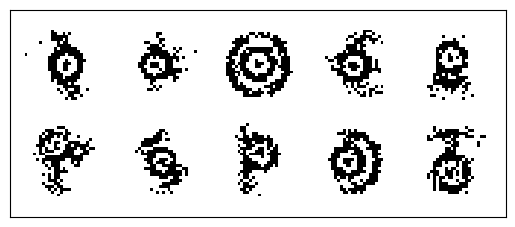

In [6]:
def image_sampler(theta, pi, num_images):
    """ Inputs: parameters theta and pi, and number of images to sample
    Returns the sampled images (N_images x N_features)"""

    # YOU NEED TO WRITE THIS PART
    num_features, num_classes = theta.shape
    class_labels = np.random.choice(num_classes, size=num_images, p=pi)
    sampled_images = np.zeros((num_images, num_features), dtype=int)
    for i in range(num_images):
        c = class_labels[i]
        sampled_images[i] = np.random.binomial(1, theta[:, c])
    return sampled_images


def plot_images(images, ims_per_row=5, padding=5, image_dimensions=(28, 28),
                cmap=matplotlib.cm.binary, vmin=0., vmax=1.):
    """Images should be a (N_images x pixels) matrix."""
    fig = plt.figure(1)
    fig.clf()
    ax = fig.add_subplot(111)

    N_images = images.shape[0]
    N_rows = np.int32(np.ceil(float(N_images) / ims_per_row))
    pad_value = vmin
    concat_images = np.full(((image_dimensions[0] + padding) * N_rows + padding,
                             (image_dimensions[1] + padding) * ims_per_row + padding), pad_value)
    for i in range(N_images):
        cur_image = np.reshape(images[i, :], image_dimensions)
        row_ix = i // ims_per_row
        col_ix = i % ims_per_row
        row_start = padding + (padding + image_dimensions[0]) * row_ix
        col_start = padding + (padding + image_dimensions[1]) * col_ix
        concat_images[row_start: row_start + image_dimensions[0],
                      col_start: col_start + image_dimensions[1]] = cur_image
        cax = ax.matshow(concat_images, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))

    plt.plot()


sampled_images = image_sampler(theta_est, pi_est, 10)
plot_images(sampled_images)

## Q2.7
[5pts] One of the advantages of generative models is that they can handle missing data, or be used to answer different sorts of questions about the model. Assume we have only observed some pixels of the image. Let $x_E = \left\{x_p : \text{pixel p is observed}\right\}$. Derive an expression for $p(x_j|x_E,\theta,\pi)$, the conditional probability of an unobserved pixel $j$ given the observed pixels and distribution parameters. (Hint: You have to marginalize over $c$.)

[Type up your derivation here]

Your answer:

$$P(x_j|x_E,\theta,\pi) = \sum_c P(x_j|c,x_E, \theta,\pi)P(c|x_E,\theta,\pi)$$

$$P(x_j|c,x_E,\theta,\pi)
=P(x_j|c,\theta)
=\theta_{cj}^{x_j}(1 - \theta_{cj})^{1-x_j}$$

By Bayes Rule,
$$
\begin{split}
P(c|x_E,\theta,\pi)
&=\frac{P(x_E|c,\theta,\pi)P(c|\theta,\pi)}{\sum_{c'}P(x_E|c',\theta,\pi)P(c'|\theta,\pi)}\\
&=\frac{P(x_E|c,\theta,\pi)P(c|\pi)}{\sum_{c'}P(x_E|c',\theta,\pi)P(c'|\pi)}
\end{split}$$

As
$$P(x_E|c,\theta)=\prod_{p \in E}\theta_{cp}^{x_p}(1-\theta_{cp})^{1-x_p},$$
then
$$
P(c|x_E,\theta,\pi)
=\frac{\prod_{p \in E}\theta_{cp}^{x_p}(1-\theta_{cp})^{1-x_p}P(c|\pi)}{\sum_{c'}\prod_{p \in E}\theta_{c'p}^{x_p}(1-\theta_{c'p})^{1-x_p}P(c'|\pi)},
$$

So,
$$
\begin{split}
P(x_j|x_E,\theta,\pi)
&=\sum_c\{\frac{\theta_{cj}^{x_j}(1 - \theta_{cj})^{1-x_j}\prod_{p \in E}\theta_{cp}^{x_p}(1-\theta_{cp})^{1-x_p}P(c|\pi)}{\sum_{c'}\prod_{p \in E}\theta_{c'p}^{x_p}(1-\theta_{c'p})^{1-x_p}P(c'|\pi)}\}\\
&=\frac{\sum_c \theta_{cj}^{x_j}(1 - \theta_{cj})^{1-x_j}\prod_{p \in E}\theta_{cp}^{x_p}(1-\theta_{cp})^{1-x_p}P(c|\pi)}{\sum_{c'}\prod_{p \in E}\theta_{c'p}^{x_p}(1-\theta_{c'p})^{1-x_p}P(c'|\pi)}
\end{split}.
$$

## Q2.8
a) [5pts] We assume that only 30% of the pixels are observed. For the first 30 images in the training set, plot the images when the unobserved pixels are left as white, as well as the same images when the unobserved pixels are filled with the marginal probability of the pixel being 1 given the observed pixels, i.e. the value of the unobserved pixel $j$ is $p(x_j = 1|x_E,\theta,\pi)$.

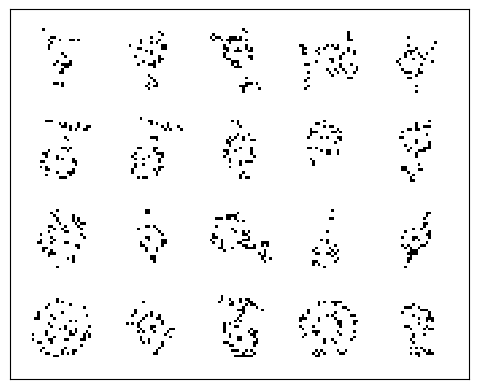

In [7]:
from logging import log
def probabilistic_imputer(theta, pi, original_images, is_observed):
    """Inputs: parameters theta and pi, original_images (N_images x N_features),
        and is_observed which has the same shape as original_images, with a value
        1. in every observed entry and 0. in every unobserved entry.
    Returns the new images where unobserved pixels are replaced by their
    conditional probability"""

    num_images, num_features = original_images.shape
    num_classes = len(pi)

    log_joint_list = []

    # Log-sum-exp trick
    for c in range(num_classes):
        log_joint0 = np.sum(
            np.tile(np.log(theta[:, c]), (num_images, 1)) * (original_images * is_observed) +
            np.tile(np.log(1 - theta[:, c]), (num_images, 1)) * ((1 - original_images) * is_observed),
            axis=1
        )
        log_joint1 = log_joint0 + np.log(pi[c])
        log_joint_list.append(log_joint1)

    log_joint = np.stack(log_joint_list, axis=1)  # (num_images, num_classes)

    log_sum_exp = np.log(np.sum(np.exp(log_joint), axis=1, keepdims=True))
    log_like = log_joint - log_sum_exp
    posterior_probs = np.exp(log_like)  # P(c | x_E)

    marginal_probs = np.dot(theta, posterior_probs.T)  # (num_features, num_images)

    new_images = original_images.copy()
    new_images[is_observed == 0] = marginal_probs.T[is_observed == 0]

    return new_images


num_features = train_images_binarized.shape[1]
is_observed = np.random.binomial(1, p=0.3, size=(20, num_features))
plot_images(train_images_binarized[:20] * is_observed)

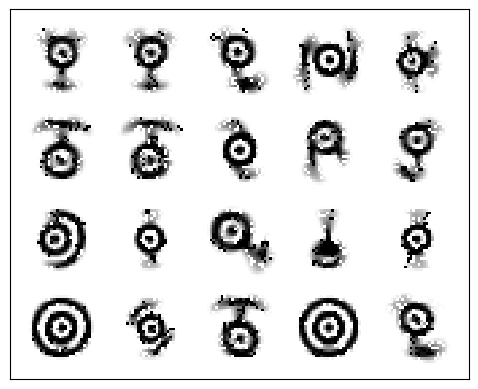

In [8]:
imputed_images = probabilistic_imputer(theta_est, pi_est, train_images_binarized[:20], is_observed)
plot_images(imputed_images)

b) [2pts] Now suppose instead of choosing the 30% observed pixels at random, we constructed a grid with roughly evenly spaced observed pixels, as follows:

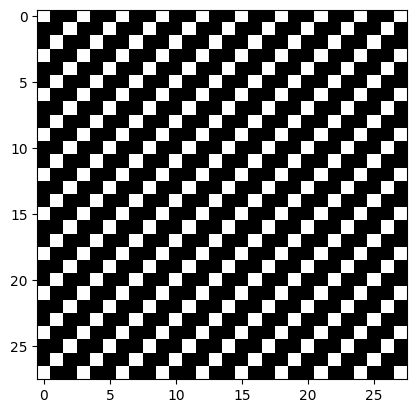

In [9]:
h, w = 28, 28
p = 0.3

num_pixels = h * w
num_indices = int(num_pixels * p)

step_size = num_pixels // num_indices

indices = [(i // w, i % w) for i in range(0, num_pixels, step_size)]
flattened_indices = [row * w + col for row, col in indices]

one_hot_indices = np.zeros(num_pixels, dtype=int)
for index in flattened_indices:
    one_hot_indices[index] = 1

one_hot_matrix = one_hot_indices.reshape(h, w)

import matplotlib.pyplot as plt
plt.imshow(one_hot_matrix, cmap='gray')
plt.show()

Next we impute as before, except using this grid of observed indices.

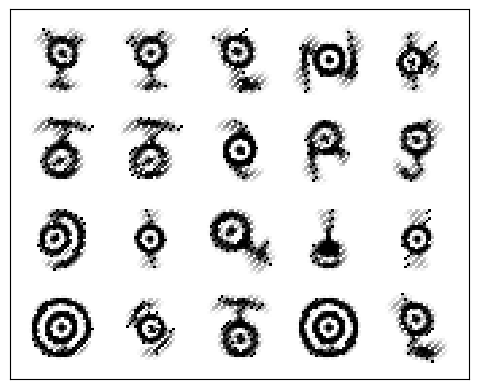

In [10]:
repeated_one_hot_indices = np.tile(one_hot_indices, (20, 1))
imputed_images = probabilistic_imputer(theta_est, pi_est, train_images_binarized[:20], repeated_one_hot_indices)
plot_images(imputed_images)

Compare the resulting images you found when using the probabilistic_imputer in part 2.8 a) (random 30% observed) and 2.8 (evenly spaced 30% observed).

What do you find? Why might one of the two resulting samples of images be better than the other?
(Hint: consider what the spatial properties of naturally occuring images are.)\
You can use the following ground truth images to help inform your answer.

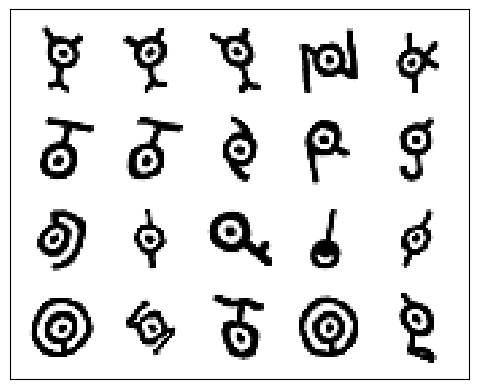

In [11]:
plot_images(train_images[:20])


**Answer:**

The evenly spaced 30% observed one is closer to the ground truth image than the random 30% observed one. The random 30% observed one looks more noisy. This is because the evenly spced 30% observed one provides a good coverage of the image, having more contextual information to predict the missing pixels. This enables the model to captures the spatial structure and pattern of the image as natural image tends to have high spatial correlations. However, random 30% observed one may have cluster pixels, leaving a huge gap, which makes the prediction harder.

## Q2.9

We now consider the Gaussian Naïve Bayes model, parameterized by $\mu$, $\Sigma$, $\pi$, to model the pixel data. Thus we revert back to representing each data sample using a continuous range of values, i.e. $x^{(i)} \in \mathbb{R}^{D}$, and we no longer use the binarized version of the data samples. (Note that in reality $x^{(i)} \in \left[0,1\right]^{D}$, but for the purposes of this question we will ignore this.) Here the joint probability distribution of $x$ and $c$ is given by $$p(x,c|\mu,\Sigma,\pi) =  p(c|\pi)p(x|c,\mu,\Sigma) = p(c|\pi)p(x|c,\mu,\Sigma),$$ where $p(x | c,\mu,\Sigma) = \frac{1}{\sqrt{\left(2\pi\right)^{D}|\Sigma_{c}|}}\exp\left(-\frac{1}{2}\left(x-\mu_{c}\right)^{T}\Sigma_{c}^{-1}\left(x-\mu_{c}\right)\right)$. As before $c|\pi$ follows a simple categorical distribution, i.e. $p(c|\pi) = \pi_c$.

[1pts] Recall in general for the normal distribution, $\Sigma_{c} \in \mathbb{R}^{D,D}$. What special form does $\Sigma_{c}$ take, in context of the Naive Bayes assumption?

[Type your answer here.]

**Answer:**

In the Gaussian Naive Bayes model, the covariance matrix $\Sigma_c$ is diagonal.

$$\Sigma_c = \text{diag}(\sigma_{c,1}^2, \sigma_{c,2}^2, \dots, \sigma_{c,D}^2)$$

Becuase the Naive Bayes assumes the conditional independence between each feature given the class.

[7pts] Derive the maximum likelihood estimates of $\mu_{c}$, $\Sigma_{c},\pi_{c}$ for all $c \in \left\{1, \ldots, 10\right\}$, then fill in the code block below with the implementation.\
(Hint: it is normal if you use a single for loop over the computation of each $\Sigma_{c}$)

**Answer :**

Let $\theta = (\pi_1, ..., \pi_K, \mu_1, ..., \mu_K, \Sigma_1, ..., \Sigma_K)$, $c\in [K]$

$$
\begin{split}
f_c(x)
&=\frac{exp\{-\frac{1}{2}(x-\mu_c)^T\Sigma_c^{-1}(x-\mu_c)\}}{(2\pi)^{\frac{D}{2}}|\Sigma_c|^{\frac{1}{2}}}\\
&=\frac{exp\{-\Sigma_{j=1}^{D}\frac{1}{2\sigma^2_{kj}}(x_j-\mu_{kj})^2\}}{(2\pi)^{\frac{D}{2}}(\prod_{j=1}^D\sigma_{cj}^2)^{\frac{1}{2}}}\\
\end{split}$$

$$L(\theta)=\prod_{i=1}^n\prod_{c=1}^K[\pi_cf_c(x_i)]^{1\{y_i=c\}}$$

$$
\begin{split}
l(\theta)
&=\sum_{i=1}^{n}\sum_{c=1}^{K}1\{y_i=c\}[log(\pi_c)+logf_c(x_i)]\\
&=\sum_{i=1}^{n}\sum_{c=1}^{K}1\{y_i=c\}[log(\pi_c)-\frac{D}{2}log(2\pi)-\frac{1}{2}\sum_{j=1}^Dlog(\sigma_{cj}^2)-\sum_{j=1}^{D}\frac{1}{2\sigma^2_{cj}}(x_{ij}-\mu_{cj})^2]\\
&=\frac{-nKD}{2}log(2\pi)+\sum_{i=1}^D\sum_{c=1}^{K-1}1\{y_i=K\}[log(1-\sum_{c=1}^{K-1}\pi_c)-\frac{1}{2}\sum_{j=1}^{D}log(\sigma^2_{Kj})-\sum_{j=1}^D\frac{1}{2\sigma_{Kj}^2}(x_{ij}-\mu_{Kj})^2]+
\sum_{i=1}^n1\{y_i=K\}[log(1-\sum^{K-1}_{c=1}\pi_c)-\frac{1}{2}\sum^D_{j=1}log(\sigma^2_{Kj})-\sum_{j=1}\frac{1}{2\sigma^2_{Kj}}(x_{ij}-\mu_{Kj})^2]
\end{split}$$

Compute maximum likelihood estimators:

Let
$$\frac{\partial l(\theta)}{\partial \mu_{cj}}
=\sum_{i=1}^D\frac{1\{y_i=k\}}{\sigma^2_{cj}}(x_{ij}-\mu_{cj})=0,$$

$$\frac{\partial l(\theta)}{\partial \sigma_{cj}^2}
=\sum_{i=1}^D1\{y_i=c\}[\frac{-1}{2\sigma^2_{cj}}+\frac{1}{2\sigma_{cj}^4}(x_{ij}-\mu_{cj})^2]=0,$$

$$\frac{\partial l(\theta)}{\partial \pi_c}
=\sum_{i=1}^n\frac{1\{y_i=c\}}{\pi_c}-\sum_{i=1}^n\frac{1\{y_i=K\}}{1-\sum_{k=1}^{K-1}\pi_c}=0.$$

Let $n_c=\sum_{i=1}^n1\{y_i=c\}$,

$$\widehat{\mu_{cj}}=\frac{1}{n_c}\sum_{i=1}^n1\{y_i=c\}x_{ij}$$

$$\widehat{\sigma_{cj}}=\frac{1}{n_c}\sum_{i=1}^{n}1\{y_i=c\}(x_{ij}-\widehat{\mu_{cj}})^2$$

$$\widehat{\pi_c}=\frac{n_c}{n}$$

In [12]:
def train_gnb_mle_estimator(train_images, train_labels, epsilon=1e-6):
    """ Inputs:
        train_images (N_samples x N_features)
        train_labels (N_samples x N_classes)
        Returns the MLE estimators mu_est, sigma_est, pi_est.
    """
    # YOU NEED TO WRITE THIS PART
    num_samples, num_features = train_images.shape
    num_classes = train_labels.shape[1]
    class_counts = np.sum(train_labels, axis=0)

    mu_est = np.zeros((num_classes, num_features))
    sigma_est = np.zeros((num_classes, num_features))
    pi_est = np.zeros(num_classes)

    # pi
    pi_est = np.sum(train_labels, axis=0) / num_samples

    # mu
    mu_est = np.dot(train_labels.T, train_images) / class_counts[:, np.newaxis]

    # sigma
    for k in range(num_classes):
        x_k = train_images[train_labels[:, k] == 1]
        square = (x_k - mu_est[k]) ** 2
        sigma_est[k, :] = np.sum(square, axis=0) / class_counts[k] + epsilon

    return mu_est, sigma_est, pi_est

## Q2.10
[6pts] Similar to before, derive an expression for the class log-likelihood $\log p(c|x,\mu,\Sigma,\pi)$ for a single image. Then, complete the implementation for computing the log_likelihoods.

As before report the average log-likelihood $\frac{1}{N}\sum_{i=1}^{N}\log p(c^{(i)}|x^{(i)},\hat{\theta},\hat{\pi})$ (where $N$ is the number of samples) on the training test, as well the training and test errors. Use the accuracy function you implemented earlier.

Note: Here because we did not find the MAP estimators for $\mu, \Sigma$ we use a technique called variance smoothing, which adds a small value $\epsilon$ to $\Sigma$ in the implementation, before computing the log-likelihoods. The subsequent part of this question comments on what one might expect if they used the MAP estimators.

**Answer:**

$$
\begin{split}
P(c|x,\mu,\Sigma,\pi)
&=\frac{P(c,x|\mu,\Sigma,\pi)}{P(x|\mu,\Sigma,\pi)}\\
&=\frac{P(c|\pi)P(x|c,\mu,\Sigma)}{\sum_{c'}P(c'|\pi)P(x|c',\mu,\Sigma)}\\
&=\frac{\pi_cP(x|c,\mu,\Sigma)}{\sum_{c'}\pi_{c'}P(x|c',\mu,\Sigma)}
\end{split}
$$

Since
$$
p(x | c,\mu,\Sigma) = \frac{1}{(2\pi)^{\frac{D}{2}}|\Sigma_c|^{\frac{1}{2}}}\exp(-\frac{1}{2}(x-\mu_{c})^{T}\Sigma_{c}^{-1}(x-\mu_{c})),
$$

then
$$
logp(x | c,\mu,\Sigma) = -\frac{D}{2}log(2\pi)-\frac{1}{2}log(|\Sigma_c|)-\frac{1}{2}(x-\mu_c)^T\Sigma_c^{-1}(x-\mu_c)
$$

So,
$
logP(c|x,\mu,\Sigma,\pi)
=log\pi_c+logP(x|\mu,\Sigma,\pi)-log(\sum_{c'}\pi_{c'}P(x|c',\mu,\Sigma))\\
=log\pi_c-\frac{D}{2}log(2\pi)-\frac{1}{2}log(|\Sigma_c|)-\frac{1}{2}(x-\mu_c)^T\Sigma_c^{-1}(x-\mu_c)\\
-log(\sum_{c'}\pi_{c'}\frac{1}{(2\pi)^{\frac{D}{2}}|\Sigma_c|^{\frac{1}{2}}}\exp(-\frac{1}{2}(x-\mu_{c'})^{T}\Sigma_{c'}^{-1}(x-\mu_{c'})))$

In [13]:
def gnb_log_likelihood(images, mu, sigma, pi, epsilon):
    sigma = sigma + epsilon

    total_samples, total_features = images.shape
    total_classes = mu.shape[0]

    log_likelihoods = np.zeros((total_samples, total_classes))

    for c in range(total_classes):
        # Compute log determinant term (-1/2 * log(|Σ_c|))
        log_det_sigma = -0.5 * np.sum(np.log(sigma[c]))  # Since sigma is diagonal

        # Compute quadratic term (-1/2 * (x - μ_c)^T Σ_c^{-1} (x - μ_c))
        inv_sigma = 1 / sigma[c]
        diff = images - mu[c]
        quadratic_term = -0.5 * np.sum(diff ** 2 * inv_sigma, axis=1)

        # Compute final log-likelihood (log P(x | c, μ, Σ))
        log_prior = np.log(pi[c])
        log_likelihoods[:, c] = log_prior - 0.5 * total_features * np.log(2 * np.pi) + log_det_sigma + quadratic_term

    return log_likelihoods

N_data, train_images, _, train_labels, test_images, _, test_labels = load_unown_mnist()
mu_est, sigma_est, pi_est = train_gnb_mle_estimator(train_images, train_labels)

epsilon = 1e-05
loglike_train = gnb_log_likelihood(train_images, mu_est, sigma_est, pi_est, epsilon)
avg_loglike = np.sum(loglike_train * train_labels) / N_data
train_accuracy = accuracy(loglike_train, train_labels)
loglike_test = gnb_log_likelihood(test_images, mu_est, sigma_est, pi_est, epsilon)
test_accuracy = accuracy(loglike_test, test_labels)

print(f"Average log-likelihood for MLE (with variance smoothing) is {avg_loglike:.3f}")
print(f"Training accuracy for MLE (with variance smoothing) is {train_accuracy:.3f}")
print(f"Test accuracy for MLE (with variance smoothing) is {test_accuracy:.3f}")

Average log-likelihood for MLE (with variance smoothing) is 1803.901
Training accuracy for MLE (with variance smoothing) is 0.998
Test accuracy for MLE (with variance smoothing) is 0.995


Using a small value of $\epsilon$ is a crude way of circumventing the problem of using the MLE directly.

The MAP for the Gaussian Naive Bayes can be obtained with the help of the conjugate prior for the multivariate normal distribution, which is the [normal-inverse-Wishart](https://en.wikipedia.org/wiki/Normal-inverse-Wishart_distribution). We will not derive the MAP for the Gaussian Naive Bayes here - but one can still appreciate the benefit of doing so by drawing a comparison to what was found for the Bernoulli Naive Bayes, when $\alpha=2$ was used as compared with $\alpha=1$.